# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [1]:
import twitter
import os
import time
import json
import pandas as pd
import numpy as np

In [2]:
CONSUMER_KEY = ""
CONSUMER_SECRET = ""

ACCESS_TOKEN_KEY = ""
ACCESS_TOKEN_SECRET = ""

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [6]:
from twitter.ratelimit import RateLimit

def get_user_tweets(user_id):
    """returns list of tweets as dicts"""
    twits = []
    try:
        statuses = api.GetUserTimeline(user_id=user_id, count = 200, include_rts= False, exclude_replies = True)
        for s in statuses:
            twits.append(s.AsDict())  
    except twitter.TwitterError as e:
        print 'Exception at uid ', user_id, ': ', e.message
        if e.message == 'Not authorized.':
            pass
        elif e.message[0]['message'] == 'Sorry, that page does not exist.':
            pass
        elif e.message[0]['message'] == 'Rate limit exceeded':
            try:
                time.sleep(60) 
                pass
            except:
                raise
        else:
            raise

    return twits


In [7]:
TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.head()

,uid,cls
0,202388889,1
1,1392518336,0
2,361208576,1
3,1535215357,1
4,4396196375,1


## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [8]:
import re

def links(text):
    return re.sub(r'https?\:\/\/.*[\r\n]*.*', '', text, flags=re.MULTILINE)

signs=",.;?! "

def get_words(text):
    """returns list of words"""
    text = links(text)
    words=[]
    current_word=''
    for symbol in text:
        if symbol in signs:
            if current_word: words.append(current_word)
            current_word=''
        else:
            current_word+=symbol
    return words

In [9]:
res = get_user_tweets(783836768)
print get_words(res[0]['text'])

[u'Is', u'this', u'at', u'hint', u'at', u'Super', u'Street', u'Fighter', u'V']


Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

In [10]:
import nltk
#nltk.download()

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [11]:
def get_tokens(words):
    """returns list of tokens"""
    tokens = []
    stop_words = nltk.corpus.stopwords.words('english')
    stop_words = set(stop_words)
  
    for word in words:
        word = nltk.stem.WordNetLemmatizer().lemmatize(word, 'v')
        if word not in stop_words:
            tokens.append(word)
    return tokens 

In [12]:
print get_tokens(["here", "are", "different", "words"])

['different', u'word']


Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [13]:
def get_tweet_tokens(tweet):
    words = get_words(tweet)
    return get_tokens(words)

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [14]:

def collect_users_tokens(df_users):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""
    users, token = [], []
    record = []
    tweet_list = []
    i=0
    for user in df_users['uid']:
        i=i+1
        print 'Обработан пользователь', i
        record = get_user_tweets(user)
        try:
            tweet_list = get_tweet_tokens(record[0]['text'])
        
            dictionary = {}
            for word in tweet_list:                
                if dictionary.get(word) != None:
                    dictionary[word] += 1
                else:
                    dictionary[word] = 1
           
            users.append(int(user))
            token.append(dictionary)
        except:
            pass 
     
    return users, token

In [18]:
import pandas as pd
from collections import defaultdict
import json
from sklearn.feature_extraction import DictVectorizer


users, users_tokens = collect_users_tokens(df_users)
v = DictVectorizer()
vs = v.fit_transform(users_tokens)


In [17]:
import numpy as np
np.savez("out_4.dat", data=vs, users=users, users_tokens=users_tokens )

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

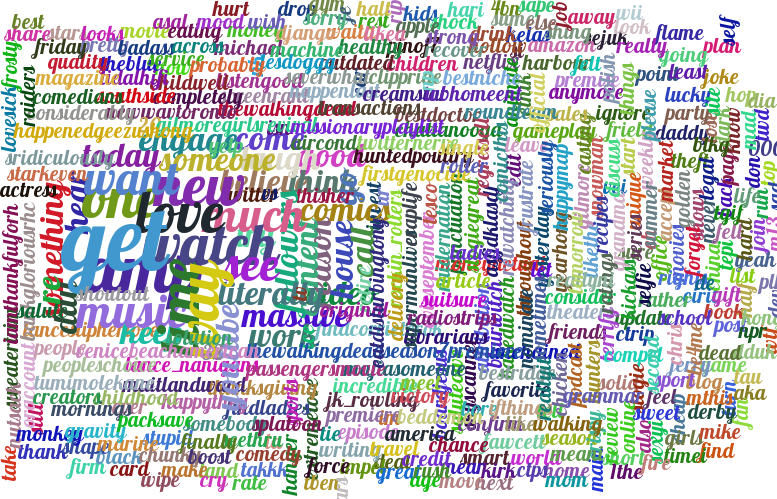

In [17]:
data = np.load('out_4.dat.npz')
a = data['users_tokens']

from pytagcloud import create_tag_image, make_tags
from pytagcloud.lang.counter import get_tag_counts
from IPython.display import Image

def draw_tag_cloud(users_tokens):
    """Draws tag cloud of found tokens"""
    YOUR_TEXT = ''
    for i in range(80):
        myList = a[i].keys()
        myString = ' '.join(myList)
        YOUR_TEXT = YOUR_TEXT + myString

    tags = make_tags(get_tag_counts(YOUR_TEXT), maxsize=80)

    create_tag_image(tags, 'cloud_large.png', size=(800, 500), fontname='Lobster')


    return Image('cloud_large.png')

draw_tag_cloud(a)

